# From in-vitro Panels to Virtual Screening Models 

Prepared to accompany talk for NIH.AI workshop on 23-Oct 2019. This notebook is an example of a method only and is not meant to demonstrate effective modeling techniques for cancer dose-response models. 

Please contact Austin Clyde, aclyde@anl.gov, for questions regarding the content in this notebook. 

## Setup environment. 
I recommend using Conda to manage the python environment. Some modules used later on will require Conda to avoid custom C builds. For the neural network section, running this code on a GPU is highly recommended to keep runtimes in a reasonable number, if you do not have a GPU available, please reduce the data size parameter in the sections below. 

```shell
cd <this directory>
conda create ...
conda activate 
```



In [2]:
import pandas as pd
import numpy as np
import sklearn.preprocessing

from matplotlib import pyplot as plt
%matplotlib inline

class Avg:
    def __init__(self):
        self.sum = 0
        self.count = 0
    def __call__(self, i):
        self.sum += i
        self.count += 1
    
    def avg(self):
        return self.sum / self.count
        

## Get data
As mentioned in the presentation, to keep this code applicable, I tried to keep this notebook as general as possible for panel and screening problems. We will define our panel as having $N$ observations consisting of a tumor and drug, $N_t$ tumor cells which we draw from, and $N_d$ drugs.

$$\hat{R}=\hat{f}_\theta (\mathcal{T}, \mathcal{D})$$
we can think of this as neededing three data tables, $R$, $T$, and $D$.

- $R$ is $N$ by $3$ and is our response variable, most commonly referred to as $y_\text{obsesrved}$. 
- $T$ is $N_t$ by $\mid{F_t}\mid$ and is our characterization of the tumor cells. $F_t$ can be anything from encoding the name of the cell to the type, even RNA-seq quantification.
- $D$ is $N_d$ by $\mid{F_d}\mid$ and is our characterization of the drug cells. $F_d$ can be anything from the name of the drug to the type of drug to various properties.

Notice so far that in our set of this problem, we have kept it general enough that you could swap out these datasets with any two variables panel your lab may use. For binding affinity predictions, we can swap T, tumor cells, to P for protein mutants or protein sequences.
### Loading data

In [2]:
df_R = pd.read_csv("/Users/austin/combined_single_response_agg", sep='\t', engine='c', low_memory=False)
unique_cells, unique_drugs = list(set(df_R.CELL)), list(set(df_R.DRUG))

df_T = pd.DataFrame({'CELL' : unique_cells, 'FEATURE' : unique_cells})# get feature frames just by the name of the cell
df_D = pd.DataFrame({'DRUG' : unique_drugs, 'FEATURE' : unique_drugs})# get feature frames just by the name of the drug

It just so turns out that our $R$ data frame has lots of extra columns we will not be using. We will remove those for the sake of generality.

In [3]:
df_R = df_R[['CELL', 'DRUG', 'AUC']]
df_R.head()

,CELL,DRUG,AUC
0,CCLE.1321N1,CCLE.1,0.8330
1,CCLE.1321N1,CCLE.10,0.7909
2,CCLE.1321N1,CCLE.11,0.5255
3,CCLE.1321N1,CCLE.12,0.8532
4,CCLE.1321N1,CCLE.14,0.5688


Notice our featurization method initially is just the name of the cell or name of the drug (this is obviously not the best way!)

In [4]:
df_T.head()

,CELL,FEATURE
0,CCLE.MFE280,CCLE.MFE280
1,CTRP.KASUMI-1,CTRP.KASUMI-1
2,gCSI.SU-86-86,gCSI.SU-86-86
3,CTRP.BT139,CTRP.BT139
4,CTRP.HEC-251,CTRP.HEC-251


In [46]:
df_D.head()

,DRUG,FEATURE
0,NSC.641536,NSC.641536
1,NSC.689732,NSC.689732
2,NSC.153365,NSC.153365
3,NSC.626117,NSC.626117
4,NSC.711897,NSC.711897


*a good habit is to look at the distribution of the target you want to predict. The skewness or normality of this distribution will significantly influence our choices in models later on*

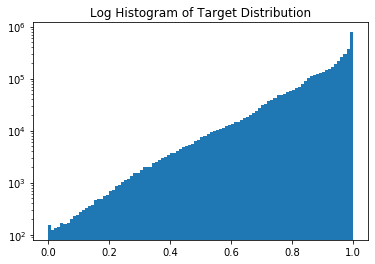

In [5]:
plt.hist(df_R.AUC, bins=100)
plt.yscale('log')
plt.title("Log Histogram of Target Distribution")
plt.show()

Take note that our response distribution is very skewed to the right. In fact, if we bin the distribution at 0.5, only 2% of our data would be labeled as a positive class.

## First attempt at Machine Learning
Okay, great, we have our response data frame, and have the most basic characterization of the tumor and drug features. Now comes the somewhat tricky part of the data preparation. We need to perform a join over the data:

tmp = JOIN($R$, $T$, on='CELL')

JOIN(tmp, $D$, on='CELL)

but in pandas, it is confusingly called merge... 

**This may require a lot of memory and take awhile. I recommend just for development and playing around with this notebook, reducing the number of samples you are using in $R$.**

In [6]:
## REDUCE DATA BY RUNNING THIS CELL
nsamples_to_use = 1000
df_R = df_R.iloc[:nsamples_to_use]

tmp = pd.merge(left=df_R, right=df_T, on='CELL', how='inner')
df = pd.merge(left=tmp, right=df_D, on='DRUG', how='inner')
df = df.drop(['CELL', 'DRUG'], axis=1) # remove the columns we used for merging feature frames
df.head() 

,AUC,FEATURE_x,FEATURE_y
0,0.8330,CCLE.1321N1,CCLE.1
1,0.7153,CCLE.22RV1,CCLE.1
2,0.8126,CCLE.42MGBA,CCLE.1
3,0.7833,CCLE.5637,CCLE.1
4,0.7675,CCLE.639V,CCLE.1


As you can see, we have both features merely being the name of the corresponding cell line or drug assigned by the respective cancer study. We call this type of labeling categorical data, and it needs to be encoded for use in machine learning algorithms (no math equation can understand "CCLE.14"). 

One example of this is an ordinal encoder. We will take each drug and provide it a number
- CCLE.1 -> 0
- CCLE.2 -> 1
- NSC.2312 -> 2
- ...

and similar for drugs

In [7]:
oridinal_encoder = sklearn.preprocessing.OrdinalEncoder()
df.iloc[:,1:] = oridinal_encoder.fit_transform(df.iloc[:,1:])
df.sample(frac=1).head() #df.sample(frac=1) just shuffles it so you can see different FEATURE_x and FEATURE_y values

,AUC,FEATURE_x,FEATURE_y
544,0.8276,29.0,15.0
499,0.8446,27.0,14.0
995,0.8230,34.0,11.0
636,0.5810,35.0,17.0
935,0.8211,8.0,8.0


In [8]:
X, y = np.array(df.iloc[:,1:]), np.array(df.iloc[:,0], dtype=np.float32)
print(X.shape, y.shape)

(1000, 2) (1000,)


In [9]:
# Linear Regression Model and RandomForest Regrerssor
import sklearn.ensemble
import sklearn.linear_model
import sklearn.model_selection

cv = sklearn.model_selection.KFold(5, random_state=42)
lin_avg_r2 = Avg()
for i, (train, test) in enumerate(cv.split(X,y)):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
    lr = sklearn.linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    test_r2 = lr.score(X_test, y_test)
    print("Cross fold ", i, ":", test_r2)
    lin_avg_r2(test_r2)
    
cv = sklearn.model_selection.KFold(5, random_state=42)
rf_avg_r2 = Avg()
for i, (train, test) in enumerate(cv.split(X,y)):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
    lr = sklearn.ensemble.RandomForestRegressor(n_estimators=10, n_jobs=-1)
    lr.fit(X_train, y_train)
    test_r2 = lr.score(X_test, y_test)
    print("Cross fold ", i, ":", test_r2)
    rf_avg_r2(test_r2)
    
print("Linear Model Avg: ", lin_avg_r2.avg())
print("RF Model Avg: ", rf_avg_r2.avg())

Cross fold  0 : -0.06151623805760687
Cross fold  1 : -0.06260157493806284
Cross fold  2 : -0.08526507335845858
Cross fold  3 : 0.030034655687436684
Cross fold  4 : 0.10972354098322945
Cross fold  0 : -0.7048934811029846
Cross fold  1 : -1.0182151689274321
Cross fold  2 : -1.5111994908687436
Cross fold  3 : -0.29620104423368
Cross fold  4 : -0.452865742271803
Linear Model Avg:  -0.013924937936692427
RF Model Avg:  -0.7966749854809286


We can see that this featurization method is suboptimal. Let us try considering this as a regression case, remember we can turn it into one by binning

In [10]:
CUTOFF = 0.5

import sklearn.ensemble
import sklearn.linear_model
import sklearn.model_selection

# StratifiedKFold attempts to keep y values distributed evenly across folds. Useful for classification
cv = sklearn.model_selection.StratifiedKFold(5, random_state=42, shuffle=True)
lin_avg_acc = Avg()
for i, (train, test) in enumerate(cv.split(X,y <= CUTOFF)):
    X_train, X_test, y_train, y_test = X[train], X[test], (y[train] <= CUTOFF).astype(np.int32), (y[test] <= CUTOFF).astype(np.int32)
    
    lr = sklearn.linear_model.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    test_acc = lr.score(X_test, y_test)
    print("Cross fold ", i, ":", test_acc)
    lin_avg_acc(test_acc)
    
# StratifiedKFold attempts to keep y values distributed evenly across folds. Useful for classification
cv = sklearn.model_selection.StratifiedKFold(5, random_state=42, shuffle=True)
rf_avg_acc = Avg()
for i, (train, test) in enumerate(cv.split(X,y <= CUTOFF)):
    X_train, X_test, y_train, y_test = X[train], X[test], (y[train] <= CUTOFF).astype(np.int32), (y[test] <= CUTOFF).astype(np.int32)
    
    lr = sklearn.ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)
    lr.fit(X_train, y_train)
    test_acc = lr.score(X_test, y_test)
    print("Cross fold ", i, ":", test_acc)
    rf_avg_acc(test_acc)
    
print("Linear Model Avg: ", lin_avg_acc.avg())
print("RF Model Avg: ", rf_avg_acc.avg())

Cross fold  0 : 0.9054726368159204
Cross fold  1 : 0.905
Cross fold  2 : 0.905
Cross fold  3 : 0.905
Cross fold  4 : 0.9095477386934674
Cross fold  0 : 0.945273631840796
Cross fold  1 : 0.945
Cross fold  2 : 0.92
Cross fold  3 : 0.945
Cross fold  4 : 0.9346733668341709
Linear Model Avg:  0.9060040751018775
RF Model Avg:  0.9379893997349933


Seems impressive, right? 

In [51]:
CUTOFF = 0.5

import sklearn.ensemble
import sklearn.linear_model
import sklearn.model_selection

# StratifiedKFold attempts to keep y values distributed evenly across folds. Useful for classification
cv = sklearn.model_selection.StratifiedKFold(5, random_state=42, shuffle=True)
lin_avg_acc = Avg()
lin_avg_balacc = Avg()
for i, (train, test) in enumerate(cv.split(X,y <= CUTOFF)):
    X_train, X_test, y_train, y_test = X[train], X[test], (y[train] <= CUTOFF).astype(np.int32), (y[test] <= CUTOFF).astype(np.int32)
    
    lr = sklearn.linear_model.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    test_acc = lr.score(X_test, y_test)
    print("Cross fold ", i, ":", test_acc)
    lin_avg_acc(test_acc)
    lin_avg_balacc(sklearn.metrics.balanced_accuracy_score(y_test, lr.predict(X_test)))


# StratifiedKFold attempts to keep y values distributed evenly across folds. Useful for classification
cv = sklearn.model_selection.StratifiedKFold(5, random_state=42, shuffle=True)
rf_avg_acc = Avg()
rf_avg_balacc = Avg()
for i, (train, test) in enumerate(cv.split(X,y <= CUTOFF)):
    X_train, X_test, y_train, y_test = X[train], X[test], (y[train] <= CUTOFF).astype(np.int32), (y[test] <= CUTOFF).astype(np.int32)
    
    lr = sklearn.ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)
    lr.fit(X_train, y_train)
    test_acc = lr.score(X_test, y_test)
    print("Cross fold ", i, ":", test_acc)
    rf_avg_acc(test_acc)
    rf_avg_balacc(sklearn.metrics.balanced_accuracy_score(y_test, lr.predict(X_test)))
    
print("Linear Model Avg: ", lin_avg_acc.avg(), 
      "BalAcc", lin_avg_balacc.avg())
print("RF Model Avg: ", rf_avg_acc.avg(), 
      "BalAcc", rf_avg_balacc.avg())

/Users/austin/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Cross fold  0 : 0.9157175398633257


/Users/austin/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Cross fold  1 : 0.9152619589977221


/Users/austin/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Cross fold  2 : 0.9161731207289294


/Users/austin/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Cross fold  3 : 0.9179206566347469


/Users/austin/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Cross fold  4 : 0.9174646602827178
Cross fold  0 : 0.8779043280182233
Cross fold  1 : 0.875626423690205
Cross fold  2 : 0.8783599088838269
Cross fold  3 : 0.8732330141358869
Cross fold  4 : 0.8736890104879161
Linear Model Avg:  0.9165075873014885 BalAcc 0.49891481561656487
RF Model Avg:  0.8757625370432118 BalAcc 0.49037743652054255


But notice that the accuracy balanced across both the positive and negative classes is only 75%, and the confusion matrix shows the model is mostly just guessing everything does not respond, and it does quite well at that. By noticing this, we can be cautious of understanding when our model is successful and when it is not.

In [72]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[sklearn.utils.multiclass.unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
#    plt.show()
    return ax



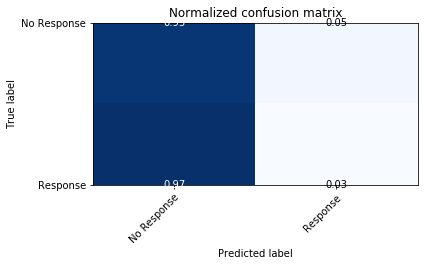

In [73]:
import utils as my_utils
ax = plot_confusion_matrix(y_test, (lr.predict(X_test) ).astype(np.int32), classes=np.array(['No Response', 'Response']), normalize=True)
plt.show()

### Metrics
Notice the import for the confusion matrix:
```python
import utils as my_utils
```
There are methods in there used throughout this notebook. They are pretty self explanatory so I will not go into them, but feel free to check them out. 

## Overview of ML so far:
So far we created two basic models, a linear model and a random forest model for regression and classification. We only applied the machine learning on a basic two feature data set where we charatized both cells and drugs by their identity, passing them to the machine learning algorithm aas simple ordinal labelings to identify the label (where we typically would use strings instead of numbers). 

We applied five fold cross validaiton, and one should also have seen how composable the models are. For instance, we could have done this entire first past as simply as this. Further this example illistates how ML code is extremely composable and iterable. In this example, we combine everything into a simple summary of tables over regression/classif understandings of the data, over various model types, and over different cross folds. Feel free to play around with this, extending the model list to include things like SVMs or gradient boosting. 


In [74]:
import utils as my_utils
from tabulate import tabulate

classif_models = [sklearn.ensemble.RandomForestClassifier, sklearn.linear_model.LogisticRegression]
reg_models = [sklearn.ensemble.RandomForestRegressor, sklearn.linear_model.LinearRegression]

model_perf = {}
for use_binned, problem_type in [(True, classif_models), (False, reg_models)]:
    y_ = (y <= CUTOFF).astype(np.int32) if use_binned else y
    score_func = my_utils.get_bclassif_metrics if use_binned else my_utils.get_regression_metrics
    model_scores = []
    for model in problem_type:
        cv = (sklearn.model_selection.StratifiedKFold if use_binned else sklearn.model_selection.KFold)(2)
        avg_metrics = my_utils.DictAvg()
        for train, test in cv.split(X,y_):
            X_train, X_test, y_train, y_test = X[train], X[test], y_[train], y_[test]
            m = model()
            m.fit(X_train, y_train)
            avg_metrics(score_func(y_test, m.predict(X_test)))
        model_scores.append(avg_metrics)

    model_perf['classif' if use_binned else 'reg'] = model_scores

for key in model_perf.keys():
    print("Model Selection Results, %s:" % key)
    tmp_scores = pd.DataFrame.from_dict([v.avg() for v in model_perf[key]])
    print(tabulate(tmp_scores, tablefmt='psql',headers=tmp_scores.columns))

/Users/austin/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/austin/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/austin/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/austin/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/austin/anaconda3/envs/tfenv/lib/python3

Model Selection Results, classif:
+----+----------+----------+-----------+-------------+----------+----------+----------+----------+----------+
|    |      acc |   balacc |       mcc |   precision |   recall |       tp |       fp |       tn |       fn |
|----+----------+----------+-----------+-------------+----------+----------+----------+----------+----------|
|  0 | 0.690295 | 0.539585 | 0.0657106 |   0.549778  | 0.360415 | 0.360415 | 0.281244 | 0.718756 | 0.718756 |
|  1 | 0.625038 | 0.554821 | 0.0677625 |   0.0506765 | 0.471396 | 0.471396 | 0.361755 | 0.638245 | 0.638245 |
+----+----------+----------+-----------+-------------+----------+----------+----------+----------+----------+
Model Selection Results, reg:
+----+-----------+----------+----------------------+
|    |        r2 |      mae |   mean_squared_error |
|----+-----------+----------+----------------------|
|  0 | -0.492116 | 0.136996 |            0.037855  |
|  1 | -0.096791 | 0.128003 |            0.0247447 |
+----+-----

# Adding in Feature Data for one variable
This was not a particularly useful exercise towards getting a good model, but rather an attempt at the most basic and general approach to this problem. Let's start by increasing the complexity by introducing RNA-seq features. Again we assume these features come pre-scaled. We will think again we do not have any drug features, just the name.  

There are two options to think about now that we have features:
- By drug model: we create, say, 100 models one for each drug. One of these models, say the "Paclitaxel model," takes in the RNA-seq of a cell, and predicts whether it will respond or not (classification, or it can predict the AUC, regression) **(Single task model)**
- Combined model: this model takes both a drug name and the cell RNA-seq and performs the same task.  **(Multitask model)**

We call the latter type of model a multi-task model as the features for drugs are like lookup tables to the model. The model gets some vector of RNA-seq and a drug name, it can use that drug name to look up some small model it has internally to then use that prediction on. Classical machine learning is very good at multi-tasking, but deep learning is. We will explore this distinction. 

In [4]:
df_T = pd.read_csv("/Users/austin/data/dose_response_data/data/cell/combined_rnaseq_data_lincs1000_combat", sep='\t')
df_T.head()

,Sample,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,CCLE.22RV1,5.797,4.390,2.350,3.383,5.930,3.684,0.925,2.404,3.744,...,1.421,3.158,1.918,2.498,3.146,2.885,2.9770,2.1130,2.1210,2.920
1,CCLE.2313287,6.516,3.787,2.020,4.848,5.844,5.460,2.137,1.829,4.350,...,1.910,3.113,2.176,2.630,2.344,2.037,3.0550,1.8590,2.0430,3.049
2,CCLE.253J,4.965,3.947,1.747,3.840,5.480,5.156,1.124,2.000,2.940,...,1.421,2.021,1.264,2.791,1.440,1.451,0.9653,1.0830,0.6484,1.126
3,CCLE.253JBV,5.203,3.586,2.270,4.600,5.812,4.900,1.523,2.252,2.818,...,1.818,2.205,1.451,2.703,2.234,2.008,1.1110,0.9320,1.1340,1.606
4,CCLE.42MGBA,5.260,4.080,1.178,5.336,4.914,4.750,2.336,3.018,3.678,...,3.150,1.499,2.404,3.219,1.789,2.387,2.0550,0.9116,0.7485,3.219


Ah but we want that first column name to be CELL

In [5]:
cell_colnames = df_T.columns.tolist()
cell_colnames[0] = 'CELL'
df_T.columns = cell_colnames
df_T.head()

,CELL,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,CCLE.22RV1,5.797,4.390,2.350,3.383,5.930,3.684,0.925,2.404,3.744,...,1.421,3.158,1.918,2.498,3.146,2.885,2.9770,2.1130,2.1210,2.920
1,CCLE.2313287,6.516,3.787,2.020,4.848,5.844,5.460,2.137,1.829,4.350,...,1.910,3.113,2.176,2.630,2.344,2.037,3.0550,1.8590,2.0430,3.049
2,CCLE.253J,4.965,3.947,1.747,3.840,5.480,5.156,1.124,2.000,2.940,...,1.421,2.021,1.264,2.791,1.440,1.451,0.9653,1.0830,0.6484,1.126
3,CCLE.253JBV,5.203,3.586,2.270,4.600,5.812,4.900,1.523,2.252,2.818,...,1.818,2.205,1.451,2.703,2.234,2.008,1.1110,0.9320,1.1340,1.606
4,CCLE.42MGBA,5.260,4.080,1.178,5.336,4.914,4.750,2.336,3.018,3.678,...,3.150,1.499,2.404,3.219,1.789,2.387,2.0550,0.9116,0.7485,3.219


In [136]:
# We want to reload data as we changed things in cells up above, and df_R was modifed
df_R = pd.read_csv("/Users/austin/combined_single_response_agg", sep='\t', engine='c', low_memory=False)

#reduce samples to make this run faster, this time to just CCLE 
df_R = df_R[df_R.SOURCE == 'CCLE'][['CELL', 'DRUG', 'AUC']]

tmp = pd.merge(left=df_R, right=df_T, on='CELL', how='inner')
df = pd.merge(left=tmp, right=df_D, on='DRUG', how='inner')
df = df.drop(['CELL', 'DRUG'], axis=1) # remove the columns we used for merging feature frames

#encode ordinal 
oridinal_encoder = sklearn.preprocessing.OrdinalEncoder()
df.iloc[:,-1] = oridinal_encoder.fit_transform(
    np.array(df.iloc[:,-1]).reshape(-1, 1) #ordinal_encoder will throw an error if you don't do this
)

X, y = np.array(df.iloc[:,1:]), np.array(df.iloc[:,0], dtype=np.float32)

df.sample(frac=1).head()

,AUC,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10,FEATURE
3957,0.8682,3.960,2.041,1.770,4.496,4.848,5.445,1.2280,2.404,3.424,...,2.553,2.572,2.2480,1.669,1.379,2.100,0.8564,0.9795,2.460,8.0
2828,0.6813,5.582,1.798,1.645,4.617,6.460,5.406,0.2299,1.729,3.756,...,3.736,2.334,2.8540,1.854,2.549,2.111,0.7880,1.1180,2.793,6.0
617,0.7810,5.420,3.244,1.383,6.707,5.930,4.285,1.7680,1.658,3.490,...,3.049,2.375,2.8460,2.201,3.309,2.190,0.7950,1.5810,3.123,1.0
6024,0.7525,3.643,2.258,1.564,4.406,5.480,3.965,2.2320,2.465,4.540,...,2.994,1.978,-0.9106,1.951,2.781,2.055,-0.1396,2.1660,2.387,13.0
2179,0.7225,4.940,3.572,2.998,5.610,6.210,3.742,2.6170,3.291,4.030,...,2.297,2.037,2.4800,2.887,2.504,2.270,1.2280,1.8050,1.628,4.0


Notice now we have numerical features that seem to be scaled, plus one ordinal feature for the drug name. Also see the data is a lot bigger now.

### Single Task Model
We will limit drugs to a single feature. This is easy as our drugs are ordinally encoded.

In [152]:
import random

# We want to reload data as we changed things in cells up above, and df_R was modifed
df_R = pd.read_csv("/Users/austin/combined_single_response_agg", sep='\t', engine='c', low_memory=False)

d = ['CCLE.18', 'GDSC.11', 'CTRP.410'] #these are all actually the same drug... confusing reality of the data.

#limit ourselves to a single d in D
df_R = df_R[df_R.DRUG.isin(d)][['CELL', 'DRUG', 'AUC']]

df = pd.merge(left=df_R, right=df_T, on='CELL', how='inner')
# NOTICE: we do not merge in drug features.
df = df.drop(['CELL', 'DRUG'], axis=1) # remove the columns we used for merging feature frames

X, y = np.array(df.iloc[:,1:]), np.array(df.iloc[:,0], dtype=np.float32)

df.sample(frac=1).head()

,AUC,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
1116,0.0541,6.332,3.5080,2.725,4.863,5.180,4.470,1.3760,2.475,4.395,...,1.3440,2.617,2.504,3.068,3.180,3.645,2.258,1.6190,2.4220,2.473
1331,0.5250,8.320,1.7350,1.895,5.810,5.344,3.898,1.9230,1.567,3.393,...,0.6167,1.930,1.670,2.846,2.777,1.350,1.685,-0.2770,2.5210,1.147
658,0.4576,4.805,3.2380,3.236,3.795,5.710,4.008,0.3628,1.255,2.707,...,1.7960,1.471,1.521,4.367,2.277,1.364,1.763,1.2070,0.7563,1.403
1322,0.6572,6.890,1.5205,1.872,4.863,5.277,5.023,1.4050,2.695,3.977,...,1.5205,2.572,1.551,2.658,1.376,3.090,2.504,0.4443,2.1660,1.489
871,0.6129,7.050,1.4720,1.292,5.883,7.074,6.190,1.1900,2.969,2.873,...,2.8440,3.260,2.492,3.469,2.777,1.744,3.908,1.9360,0.3170,3.123


In [153]:
print(X.shape, y.shape)

(1486, 942) (1486,)


(array([ 42.,  76., 183., 264., 260., 237., 160., 123.,  85.,  56.]),
 array([0.033 , 0.1297, 0.2264, 0.3231, 0.4198, 0.5165, 0.6132, 0.7099,
        0.8066, 0.9033, 1.    ]),
 <a list of 10 Patch objects>)

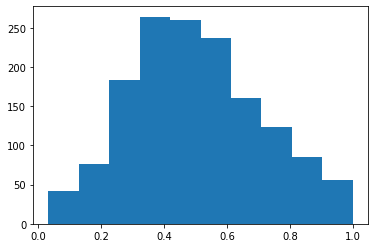

In [154]:
plt.hist(df.AUC)

In [140]:
import sklearn.linear_model 

print("Trying regression model:")
cv = sklearn.model_selection.KFold(5, random_state=42)
avg_metrics = my_utils.DictAvg()
for i, (train, test) in enumerate(cv.split(X,y)):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
    lr = sklearn.ensemble.RandomForestRegressor(n_estimators=100, n_jobs=-1)
    lr.fit(X_train, y_train)
    metrics = my_utils.get_regression_metrics(y_test, lr.predict(X_test))
    avg_metrics(metrics)

print("Avg regression metrics:")
print(my_utils.prettyPrint(avg_metrics.avg()))

print("Trying classif model:")
cv = sklearn.model_selection.StratifiedKFold(5, random_state=42)
avg_metrics = my_utils.DictAvg()
for i, (train, test) in enumerate(cv.split(X,y <= CUTOFF)):
    X_train, X_test, y_train, y_test = X[train], X[test], (y[train] <= CUTOFF).astype(np.int32), (y[test] <= CUTOFF).astype(np.int32)
    lr = sklearn.ensemble.RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)
    lr.fit(X_train, y_train)
    metrics = my_utils.get_bclassif_metrics(y_test, lr.predict(X_test))
    avg_metrics(metrics)
    
print("Avg classif Metrics")
print(my_utils.prettyPrint(avg_metrics.avg()))

Trying regression model:
Avg regression metrics:
+--------------------+----------------------+
|        key         |        value         |
+--------------------+----------------------+
|         r2         | -0.1714116976120157  |
|        mae         | 0.17067933966487694  |
| mean_squared_error | 0.044235176573293324 |
+--------------------+----------------------+
Trying classif model:
Avg classif Metrics
+-----------+---------------------+
|    key    |        value        |
+-----------+---------------------+
|    acc    |  0.6103111653447224 |
|   balacc  |  0.6082784801140948 |
|    mcc    | 0.22282677562313907 |
| precision |  0.6397175949306477 |
|   recall  |  0.6420382165605096 |
|     tp    |  0.6420382165605096 |
|     fp    | 0.42548125633232015 |
|     tn    |  0.5745187436676799 |
|     fn    |  0.5745187436676799 |
+-----------+---------------------+


In [149]:
# Single task deep learning model


# We make Keras models inside of functions so that the GPU memory is deleted when the model is finished, otherwise
# many of you would notice after a few runs, the GPU throws an out of memory error.
def cell_thunk():
    from sklearn.pipeline import Pipeline
    from keras.models import Model
    from keras.layers import Dense, Input
    from sklearn.preprocessing import MinMaxScaler
    from keras.wrappers.scikit_learn import KerasClassifier
    def set_features(feats):
        def make_model():
            input_layer = Input((feats,))
            x = Dense(16, activation='relu')(input_layer)
            x = Dense(8, activation='relu')(x)
            x = Dense(4, activation='relu')(x)
            x = Dense(1, activation='sigmoid')(x)
            model = Model(input_layer, x)

            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

            return model
        return make_model


    cv = sklearn.model_selection.StratifiedKFold(5, random_state=42)
    avg_metrics = my_utils.DictAvg()
    for i, (train, test) in enumerate(cv.split(X,y <= CUTOFF)):
        X_train, X_test, y_train, y_test = X[train], X[test], (y[train] <= CUTOFF).astype(np.int32), (y[test] <= CUTOFF).astype(np.int32)
        lr = Pipeline(memory=None, 
                        steps=[('scaling', MinMaxScaler()),
                               ('model', KerasClassifier(set_features(X.shape[1]), epochs=10, batch_size=32, verbose=0))],
                       )        
        lr.fit(X_train, y_train,  model__class_weight={0 : 1.0, 1:2.0})
        metrics = my_utils.get_bclassif_metrics(y_test, lr.predict(X_test))
        avg_metrics(metrics)
        
        del lr #clean memory
    print("Avg classif Metrics")
    print(my_utils.prettyPrint(avg_metrics.avg()))

cell_thunk()

Avg classif Metrics
+-----------+--------------------+
|    key    |       value        |
+-----------+--------------------+
|    acc    |  0.61437416672316  |
|   balacc  | 0.6035086377687001 |
|    mcc    | 0.2453325025127166 |
| precision | 0.6230476368694837 |
|   recall  | 0.7923566878980892 |
|     tp    | 0.7923566878980892 |
|     fp    | 0.585339412360689  |
|     tn    | 0.414660587639311  |
|     fn    | 0.414660587639311  |
+-----------+--------------------+


### Multitask model
Now we will use four drugs, that we featurize just 0 to 3. 

In [170]:
# We want to reload data as we changed things in cells up above, and df_R was modifed
df_R = pd.read_csv("/Users/austin/combined_single_response_agg", sep='\t', engine='c', low_memory=False)

d = ['CCLE.18', 'GDSC.11', 'CTRP.410', 
     'CCLE.24', 'GDSC.1',  'CTRP.230',
     'CCLE.2',  'GDSC.1013', 'CTRP.378',
     'CCLE.5',  'GDSC.119', 'CTRP.307'] #these each row all actually the same drug... confusing reality of the data.



#limit ourselves to a fe different drugs d in D
df_R = df_R[df_R.DRUG.isin(d)][['CELL', 'DRUG', 'AUC']]


tmp = pd.merge(left=df_R, right=df_T, on='CELL', how='inner')
df = pd.merge(left=tmp, right=df_D, on='DRUG', how='inner')
df = df.drop(['CELL', 'DRUG'], axis=1) # remove the columns we used for merging feature frames

##encode by hand to make sure  the drug names don't mess it up
df.iloc[:,-1] = df.iloc[:,-1].apply( lambda x : {'CCLE.18' : 0, 'GDSC.11'    : 0, 'CTRP.410' : 0, 
                 'CCLE.24' : 1, 'GDSC.1'     : 1,  'CTRP.230' : 1,
                 'CCLE.2'  : 2,  'GDSC.1013' : 2, 'CTRP.378' : 2,
                 'CCLE.5'  : 3,  'GDSC.119'  : 3, 'CTRP.307' : 3}[x])

X, y = np.array(df.iloc[:,1:]), np.array(df.iloc[:,0], dtype=np.float32)

df.sample(frac=1).head() #df.sample(frac=1) just shuffles it so you can see different FEATURE_x and FEATURE_y values

,AUC,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10,FEATURE
1243,0.7184,5.000,2.834,1.940,3.871,4.780,3.240,0.8877,1.225,2.785,...,1.627,1.4510,2.098,1.963,1.583,1.752,0.946,0.687,1.7030,1
3247,0.8851,5.273,2.660,1.940,2.727,6.130,3.890,-0.4058,1.688,3.360,...,3.406,0.4597,2.550,3.560,2.432,2.324,1.269,1.041,1.9375,3
4549,0.3796,4.990,3.934,4.500,5.473,5.880,3.906,2.7360,3.390,2.156,...,4.350,3.2170,3.104,2.930,2.826,2.943,1.413,1.681,1.6600,0
465,0.4907,5.203,3.550,2.633,4.360,5.414,4.700,2.1000,2.525,4.310,...,2.893,1.9870,1.990,2.908,3.191,2.234,1.200,2.004,2.6210,0
2651,0.6956,6.130,3.904,1.815,5.530,5.863,4.625,1.8560,2.475,4.890,...,3.195,2.1760,2.846,1.800,2.490,2.336,0.788,1.473,4.0620,3


In [171]:
print(X.shape, y.shape)

(6111, 943) (6111,)


In [196]:
import sklearn.linear_model 

print("Trying regression model:")
cv = sklearn.model_selection.KFold(5, random_state=42)
avg_metrics = my_utils.DictAvg()
for i, (train, test) in enumerate(cv.split(X,y)):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
    lr = sklearn.ensemble.RandomForestRegressor(n_estimators=100, n_jobs=-1)
    lr.fit(X_train, y_train)
    metrics = my_utils.get_regression_metrics(y_test, lr.predict(X_test))
    avg_metrics(metrics)

print("Avg regression metrics:")
print(my_utils.prettyPrint(avg_metrics.avg()))

print("Trying classif model:")
cv = sklearn.model_selection.StratifiedKFold(5, random_state=42)
avg_metrics = my_utils.DictAvg()
for i, (train, test) in enumerate(cv.split(X,y <= CUTOFF)):
    X_train, X_test, y_train, y_test = X[train], X[test], (y[train] <= CUTOFF).astype(np.int32), (y[test] <= CUTOFF).astype(np.int32)
    lr = sklearn.ensemble.RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)
    lr.fit(X_train, y_train)
    metrics = my_utils.get_bclassif_metrics(y_test, lr.predict(X_test))
    avg_metrics(metrics)
    
print("Avg classif Metrics")
print(my_utils.prettyPrint(avg_metrics.avg()))

Trying regression model:


Wow thats good improvement. Let's score the model by compound:

In [190]:
scores_by_drug = pd.DataFrame(np.stack([X_test[:,-1].flatten(), y_test.flatten(), lr.predict(X_test).flatten()])).T
scores_by_drug['r2'] = (scores_by_drug.iloc[:,1] == scores_by_drug.iloc[:,2])
scores_by_drug.groupby(0).mean()['r2']

0
0.0    0.556701
1.0    0.981735
2.0    1.000000
3.0    0.987288
Name: acc, dtype: float64

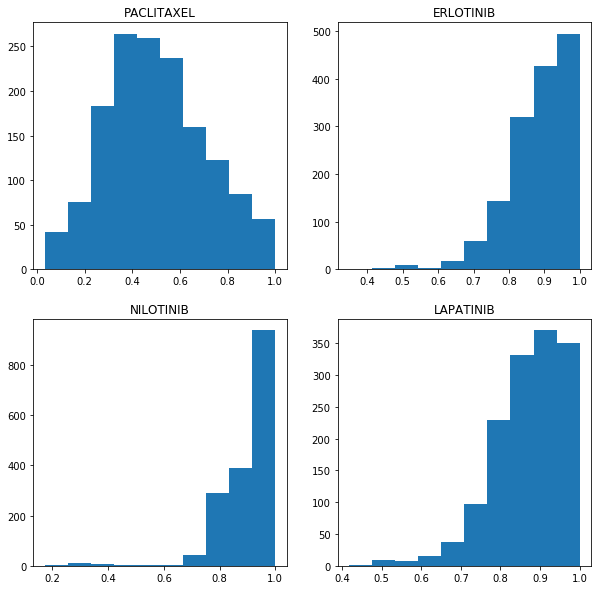

In [195]:
plt.figure(figsize=(10,10))
for i, n in enumerate(['PACLITAXEL', 'ERLOTINIB', 'NILOTINIB', 'LAPATINIB']):
    plt.subplot('22' + str(i + 1))
    plt.hist(df[df.iloc[:,-1] ==i].AUC)
    plt.title(n)

**SO we did not really do any better on paxitaxel, we just are good at predicting for the other compounds. And we're not really even better at that, we're can just predict nothing works and be basically 100% accuracte**

### Learning Curves
Learning curves are a way of expressing the relationship between dataset size and success. The following scenario is helpful for thinking about the function of learning curves. 

You are trying to convince a board to give you funding to buy 1000 more cell line screens, and they are very expensive. Your models are currently okay, but they need to be better. You need to convince the committe that adding more data will improve the model, and quantifiy that that amount of data will help you achieve that goal. 

We will make a plot that shows how our model does as we increase our data size, pretending that we have less data than we do in order to make this plot.

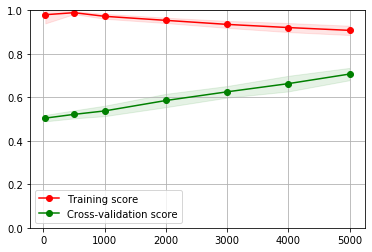

In [192]:
import sklearn.model_selection
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score,  make_scorer



pipeline = Pipeline(memory=None, 
                    steps=[('scaling', MinMaxScaler()),
                           ('model', RandomForestClassifier(n_estimators=25))]
                    )


train_sizes, train_scores, valid_scores = sklearn.model_selection.learning_curve(pipeline, 
                                                                                 X, (y <=0.5).astype(np.int32),  
                                                                                 train_sizes=[30, 500, 1000, 2000, 3000, 4000, 5000],
                                                                                 cv=10, 
                                                                                 shuffle=True,
                                                                                 verbose=0,
                                                                                 scoring=make_scorer(balanced_accuracy_score)
                                                                                )

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.ylim(0,1)
plt.show()

We can see that adding 1000 cells would indeed seem to improve our model performance. Of course this is no gaurentee, but it is strong evidence. 

I recomend learning more about this topic here: https://www.ncbi.nlm.nih.gov/pubmed/12804087 or https://arxiv.org/pdf/1712.00409

**Notice when we have an ordinal feature encoding, we must one hot encode it. Unlike other models that accept ordinal features.**

In [ ]:
# Multi-task task deep learning model

# TODO: Must one hot encode. I did not do this in the notebook for you. 

# We make Keras models inside of functions so that the GPU memory is deleted when the model is finished, otherwise
# many of you would notice after a few runs, the GPU throws an out of memory error.
def cell_thunk():
    from sklearn.pipeline import Pipeline
    from keras.models import Model
    from keras.layers import Dense, Input
    from sklearn.preprocessing import MinMaxScaler
    from keras.wrappers.scikit_learn import KerasClassifier
    def set_features(feats):
        def make_model():
            input_layer = Input((feats,))
            x = Dense(16, activation='relu')(input_layer)
            x = Dense(8, activation='relu')(x)
            x = Dense(4, activation='relu')(x)
            x = Dense(1, activation='sigmoid')(x)
            model = Model(input_layer, x)

            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

            return model
        return make_model


    cv = sklearn.model_selection.StratifiedKFold(5, random_state=42)
    avg_metrics = my_utils.DictAvg()
    for i, (train, test) in enumerate(cv.split(X,y <= CUTOFF)):
        X_train, X_test, y_train, y_test = X[train], X[test], (y[train] <= CUTOFF).astype(np.int32), (y[test] <= CUTOFF).astype(np.int32)
        
        lr = Pipeline(memory=None, 
                        steps=[('scaling', MinMaxScaler()),
                               ('model', KerasClassifier(set_features(X.shape[1]), epochs=10, batch_size=32, verbose=0))],
                       )        
        lr.fit(X_train, y_train,  model__class_weight={0 : 1.0, 1:5.0})
        metrics = my_utils.get_bclassif_metrics(y_test, lr.predict(X_test))
        avg_metrics(metrics)
        
        del lr #clean memory
    print("Avg classif Metrics")
    print(my_utils.prettyPrint(avg_metrics.avg()))

cell_thunk()

# Totally continuous model 
This is the exciting type of model we've been building up to, where we no longer restrict the model features to be a finite predetermined set such that $\mathcal{T}\subseteq\mathscr{T}=\mid n_t\mid$ or $\mathcal{D}\subseteq\mathscr{T}=\mid n_d\mid$. To really understand this important step, imagine how we have been encoding drugs as simply mapping CCLE.1 -> 34 and then when the model sees 34, it knows we are discussing this discrete drug. CCLE.4->35 versus GDSC.3 -> 1 has no indication that $d(\text{CCLE.4}, \text{GDSC.3})>d(\text{CCLE.1}, \text{CCLE.4})$. If we wanted to screen a new drug, the model would not understand the new number as it has never seen any training data. 


Models that are not continuous in all the inputs are not necesarrily bad--a model used for *precision oncology* will most likely not need to be contious on drugs as medical professionals will not be wondering if a new possible lead will work for a patient, rather of the set of known working drugs which one will work best? A model used for *drug discovery* will not need to be contious on cell information as drug companies will most likely be deveolping against a panel of screens it uses in its early lead process. *It is not well studied that continuity in any variable will improve model perforance, in fact the curse of dimensionality will likely lead one to conjecture it creates less performant models; continuity, however, does certainly improve the utility of the model.* 


Now let us consider that $\mathcal{T}\subset\mathbb{R}^{F_t}$ and $\mathcal{D}\subset\mathbb{R}^{F_d}$
where we can imagine using our JOIN operation

$$\hat{R}=\hat{f}_\theta (\mathcal{T}, \mathcal{D}) \leftrightarrow \hat{f}_\theta (\mathcal{X}) \quad\text{for} \mathcal{X}\in\mathbb{R}^{F_t + F_d}$$



In [8]:
df_D = pd.read_csv("/Users/austin/data/dose_response_data/data/drug/combined_mordred_descriptors.csv")
df_D_names = df_D.columns.tolist()
df_D_names[0] = 'DRUG'
df_D.columns = df_D_names
df_D.head()

,DRUG,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CCLE.18,48.9918,38.3185,0,0,78.4273,2.72997,5.45994,78.4273,1.26496,...,11.4933,102.4040,853.331,7.55160,14767,129,346,429,23.36110,13.21530
1,CCLE.14,24.9674,18.9098,0,1,40.2912,2.60670,5.14670,40.2912,1.29971,...,10.7835,82.3309,421.164,7.79933,2485,64,180,226,11.00690,6.54167
2,CCLE.13,34.5673,23.3780,0,1,57.5460,2.61744,5.15821,57.5460,1.33828,...,11.0186,95.7646,586.279,7.23801,7049,86,246,306,12.84030,9.26389
3,CCLE.24,21.7990,16.5705,0,0,37.7352,2.44674,4.89349,37.7352,1.30121,...,10.1163,64.0168,393.169,7.56094,2396,43,142,163,8.52778,6.83333
4,CCLE.5,31.6465,21.3953,0,1,51.1869,2.44602,4.87551,51.1869,1.27967,...,10.5379,90.6542,580.135,8.78992,6645,59,212,244,12.03470,8.56944


In [9]:
# We want to reload data as we changed things in cells up above, and df_R was modifed
df_R = pd.read_csv("/Users/austin/combined_single_response_agg", sep='\t', engine='c', low_memory=False)

#reduce samples to make this run faster, this time to just CCLE 
df_R = df_R[df_R.SOURCE == 'CCLE'][['CELL', 'DRUG', 'AUC']]

tmp = pd.merge(left=df_R, right=df_T, on='CELL', how='inner')
df = pd.merge(left=tmp, right=df_D, on='DRUG', how='inner')
df = df.drop(['CELL', 'DRUG'], axis=1) # remove the columns we used for merging feature frames


X, y = np.array(df.iloc[:,1:]), np.array(df.iloc[:,0], dtype=np.float32)

df.sample(frac=1).head()

,AUC,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
1452,0.9389,5.594,1.4850,1.997,3.262,4.332,4.934,0.9175,1.899,4.020,...,10.2846,67.8138,464.086,9.66846,3619,48,164,187,11.81250,6.97222
1895,0.6002,5.490,3.6270,1.008,4.207,4.562,5.617,1.3310,2.312,3.281,...,11.0186,95.7646,586.279,7.23801,7049,86,246,306,12.84030,9.26389
7632,0.9281,5.957,2.9100,4.190,5.184,8.240,3.898,0.9395,2.645,4.008,...,10.1163,64.0168,393.169,7.56094,2396,43,142,163,8.52778,6.83333
342,0.9251,2.844,3.3500,1.599,3.352,3.914,3.373,0.6360,0.872,2.531,...,10.6171,84.2491,439.237,7.08447,3463,50,184,221,7.47222,7.08333
6757,0.7345,4.566,0.7554,1.747,4.330,6.176,6.380,0.9250,1.971,4.195,...,10.5107,79.1959,392.176,7.84352,2281,52,164,200,8.58333,6.13889


In [10]:
print(X.shape, y.shape)

(10971, 2767) (10971,)


### classification learning curves

[learning_curve] Training set sizes: [  30  500 1000 2000 3000 5000]


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of  12 | elapsed:   14.5s remaining:  2.7min
[Parallel(n_jobs=6)]: Done   3 out of  12 | elapsed:   31.4s remaining:  1.6min
[Parallel(n_jobs=6)]: Done   5 out of  12 | elapsed:  1.0min remaining:  1.4min
/Users/austin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done   7 out of  12 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=6)]: Done   9 out of  12 | elapsed:  2.1min remaining:   42.1s
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  3.1min finished


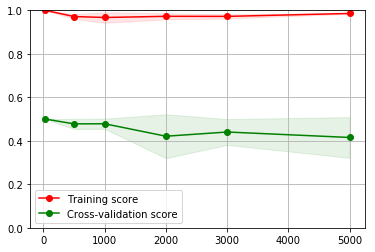

In [14]:
import sklearn.model_selection
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score,  make_scorer

pipeline = Pipeline(memory=None, 
                    steps=[('scaling', MinMaxScaler()),
                           ('model', RandomForestClassifier(n_estimators=10, n_jobs=1))]
                    )

train_sizes, train_scores, valid_scores = sklearn.model_selection.learning_curve(pipeline, 
                                                                                 X, (y <=0.5).astype(np.int32),  
                                                                                 train_sizes=[30, 500, 1000, 2000, 3000, 5000],
                                                                                 cv=2, 
                                                                                 shuffle=True,
                                                                                 verbose=10,
                                                                                 n_jobs=6,
                                                                                 scoring=make_scorer(balanced_accuracy_score)
                                                                                )

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.ylim(0,1)
plt.show()